<a href="https://colab.research.google.com/github/Banking-Analytics-Lab/DLinBankingBook/blob/main/Labs/TextBook_Lab_Chap8_FairnessandExplainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Fairness and Explainability
This lab is divided into two parts.
1. Fairness: We will assess the fairness of a credit scoring model
2. Explainability: We will use the 'shap' library to generate explanations for the language model in the lab for Chapter 3.

The two parts are independent meaining that the imports and code from one are not necessary to run the other.
We start with fairness


## Part 1: Fairness

We start by importing necessary libraries and functions.

In [2]:
!pip install fairlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [1]:
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
%matplotlib inline

from functools import partial

import fairlearn
from fairlearn.metrics import (
    MetricFrame,
    count,
    equalized_odds_difference,
    false_negative_rate,
    false_positive_rate,
    true_negative_rate,
    true_positive_rate,
    selection_rate,
)

from sklearn.metrics import accuracy_score, precision_score


In this section we will focus on assesing fairness of a credit scoring model.
For this exercise we are going to assume we have already trained the model using variables such as income, credit score and interest rates. The target variable as two values that is, non-default, indicated by 0, and default, inidcated by 1.

We are interested to know if this credit scoring model discriminates agains the sensitive attribute which is one of the variables. This variable is a proxy for race, so in essence we are measuring fairness with respect to the race of the people applying for credit.
Race is a protected characteristic by law and can therefore not be used when training the model. There may however be hidden confounding variables, which make the model unfair. Our goal is to assess this.

A dataset containing the neccessary information has been prepared

We start by reading in the dataset, which contains four variables:
- 'true_label': This it the ground truth label, that is, whether the customer defaulted or not.
- Predicted label: The label which the model predicts: 'predicted_label'
- 'predicted_probability'.  The probability of default predicted by the model. This is a number between 0 and 1.
- 'sensitive_attribute': The sensitive attribute in the dataset which we want to study from the perspective of fairness. This variable has four levels
  - 'a'
  - 'b'
  - 'c'
  - 'd'   

Note that the dataset was created for this exercise using mortgages with majorities from different ethnic profiles, using the first three digits of the postcode and census information.
This should not be considered a representative sample of those sectors. It is an illustrative example of the techniques and methods, not a showcase of differences in these places.

We start by reading in and inspecting the dataset.

In [4]:
!gdown --fuzzy 'https://drive.google.com/file/d/1XWF9WLIQbAisVTX6yiHFxJ4vK0gKPx1q/view?usp=sharing'

Downloading...
From: https://drive.google.com/uc?id=1XWF9WLIQbAisVTX6yiHFxJ4vK0gKPx1q
To: /content/FairnessDataFrame.csv
100% 206k/206k [00:00<00:00, 84.7MB/s]


In [5]:
# Read in the data
fairness_df=pd.read_csv('FairnessDataFrame.csv')
fairness_df.describe()

,true_label,predicted_label,predicted_probability,credit_score
count,6983.000000,6983.000000,6983.000000,6983.000000
mean,0.025490,0.268509,0.345760,746.887298
std,0.157621,0.443216,0.228219,46.599742
min,0.000000,0.000000,0.036601,616.000000
25%,0.000000,0.000000,0.147221,713.000000
50%,0.000000,0.000000,0.290554,755.000000
75%,0.000000,1.000000,0.519864,786.000000
max,1.000000,1.000000,0.851339,829.000000


We look at the distribution of the groups in the sensitive attribute. The barplot below shows that most people belong to group 'b', followed by group 'c' and then 'a' and 'd' which have similar counts.
We also calculate the default rate per group and see that group 'b' has the highest default rate and group 'c' the lowest, whereas groups 'a' and 'd' are similar.

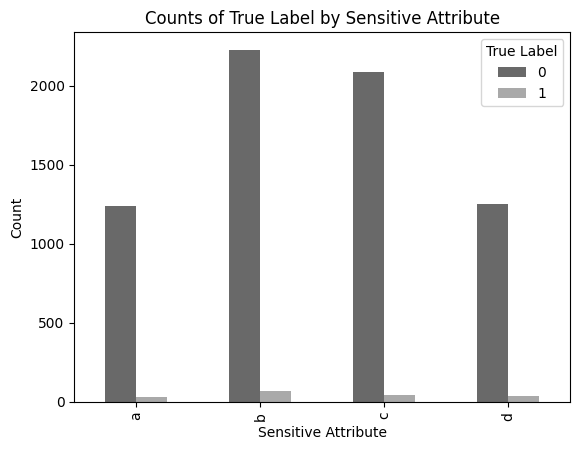

sensitive_attribute
a    2.594340
b    2.962963
c    2.017832
d    2.645914
dtype: float64


In [6]:
counts = fairness_df.groupby(['sensitive_attribute', 'true_label']).size().unstack(fill_value=0)
counts.plot(kind='bar', stacked=False, color=['dimgray', 'darkgrey'])
plt.xlabel('Sensitive Attribute')
plt.ylabel('Count')
plt.title('Counts of True Label by Sensitive Attribute')
plt.legend(title='True Label')
plt.show()

percentage_1 = counts[1] / (counts[0] + counts[1]) * 100
print(percentage_1)

Our next task is to explore the predictions made by the model for the four groups in our dataset.
For our analysis we are using the fairlearn library which allows us to inspect, measure and correct for fairness.

We start by creating a metrics dictionary listing all the metrics we want to use. This can be expanded and customized at will. Although fairlearn has many built in metrics, we need to import some additional ones from sci-kit learn.

Then we create a MetricFrame object indicating what metrics to use, and which variables for the true and predicted label and the sensitive feature. This object can be called in different ways to explore overall metrics, metrics by group as well as differences by group.

In our exploration, we plot the per-group measures for each metric.

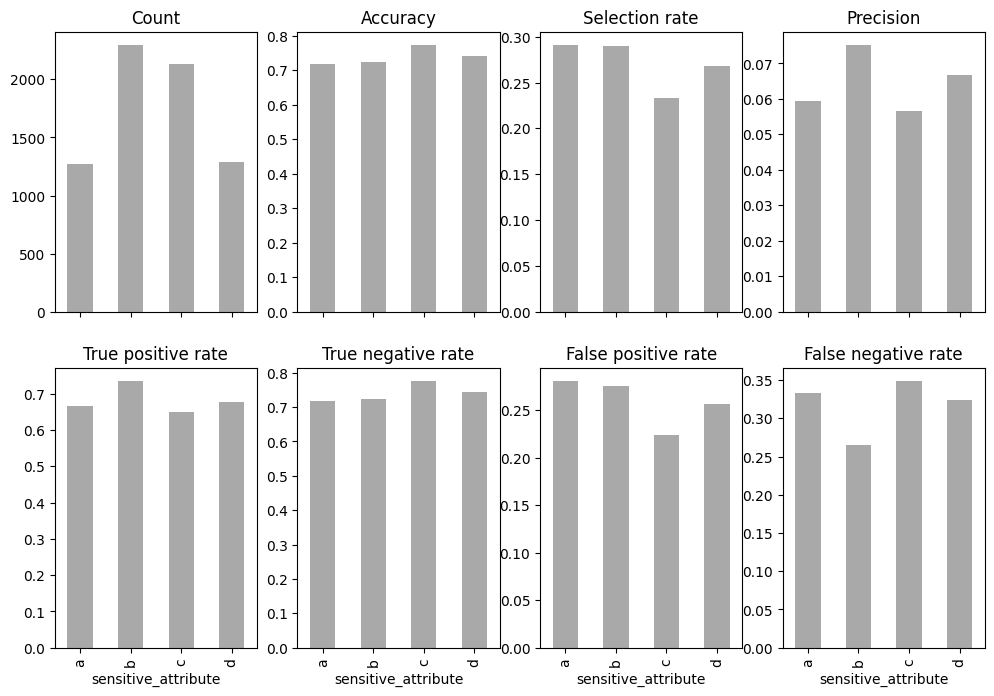

In [8]:
metrics = {
    "Count": count,
    "Accuracy": accuracy_score,
    "Selection rate": selection_rate,
    "Precision": precision_score,
    "True positive rate": true_positive_rate,
    "True negative rate": true_negative_rate,
    "False positive rate": false_positive_rate,
    "False negative rate": false_negative_rate,

}
metric_frame = MetricFrame(
    metrics=metrics, y_true=fairness_df['true_label'], y_pred=fairness_df['predicted_label'], sensitive_features=fairness_df['sensitive_attribute']
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[2, 4],
    legend=False,
    figsize=[12, 8],
    color='darkgrey'
)
plt.show()

Looking at these plots, we can see some differences between the groups:

* Count: Groups 'a' and 'd' are the smallest, followed by 'c' and 'b' which has the most people.
* Accuracy: all groups have similar accuracy although group 'c' is notably higher.  
* Selection rate: This is the fraction of observations per group which the model predicts as default. Here we notice a clear discrepancy. Notably group 'c' has the lowest selection rate, meaning that the model is less likely to predict default for the people in this group. Groups 'a' and 'b' have the highest selection rate.  This measure is relevant for assessing the independence criteria.
* Precision: This is the positive predicted value. Group 'b' has the highest value, followed by 'd', 'a' and 'c'. This measure is relevant for assessing the sufficiency criteria.
* True positive rate: This is the recall. Group 'b' has the highest value and the other three all have similar values. This measure is relevant for assessing the separation criteria.
* True negative rate: This is the specificity. All groups have very similar values.
* False positive rate: This is also the type I error. Group 'c' has the lowest value and group 'd' the second lowest value. Groups 'a' and 'b' have the highest values. This measure is relevant for assessing the separation criteria.
* False negative rate: This is also the type II error. Group 'c' has the highest value and group 'b' the lowest value. Groups 'a' and 'd' have similar values.

We can also inspect the dataframe to get summary statistics about the differences, ratio, group minimum and maximum as follows.



In [9]:
pd.DataFrame({'difference': metric_frame.difference(),
              'ratio': metric_frame.ratio(),
              'group_min': metric_frame.group_min(),
              'group_max': metric_frame.group_max()}).T

,Count,Accuracy,Selection rate,Precision,True positive rate,True negative rate,False positive rate,False negative rate
difference,1023.000000,0.055579,0.058126,0.018736,0.084131,0.056734,0.056734,0.084131
ratio,0.554248,0.928132,0.800172,0.750806,0.885581,0.926877,0.798008,0.758824
group_min,1272.000000,0.717767,0.232755,0.056452,0.651163,0.719128,0.224138,0.264706
group_max,2295.000000,0.773346,0.290881,0.075188,0.735294,0.775862,0.280872,0.348837


Lets look more closely at the three fairness criteria.

### Independence
To assess the level of independence of the sensitive attribute in the model we measure the demographic parity.

First we measure the difference and then the ratio using the specialized methods in the fairlearn library.


In [11]:
from fairlearn.metrics import demographic_parity_difference
from fairlearn.metrics import demographic_parity_ratio


DPD = demographic_parity_difference(y_true=fairness_df['true_label'],
                               y_pred=fairness_df['predicted_label'],
                                sensitive_features=fairness_df['sensitive_attribute'],
                                method="between_groups")

DPR = demographic_parity_ratio(y_true=fairness_df['true_label'],
                               y_pred=fairness_df['predicted_label'],
                                sensitive_features=fairness_df['sensitive_attribute'],
                                method='between_groups')

print(f'Demographic parity difference: {DPD:.3f}')
print(f'Demographic parity ratio: {DPR:.3f}')

Demographic parity difference: 0.058
Demographic parity ratio: 0.800


We see some slight evidence of demographic parity, as the DPD is greater than 0 and DPR is less than 1.

### Separation
Next we measure the separation using equalized odds and equal opportunity.

Equalized odds looks at both false positive and true positive rates, and we can compute their difference and ratio.

In [12]:
from fairlearn.metrics import equalized_odds_difference
from fairlearn.metrics import equalized_odds_ratio

EOD=equalized_odds_difference(y_true=fairness_df['true_label'],
                               y_pred=fairness_df['predicted_label'],
                                sensitive_features=fairness_df['sensitive_attribute'],
                                method="between_groups")

EOR=equalized_odds_ratio(y_true=fairness_df['true_label'],
                               y_pred=fairness_df['predicted_label'],
                                sensitive_features=fairness_df['sensitive_attribute'],
                                method="between_groups")

print(f'Equalized odds difference: {EOD:.3f}')
print(f'Equalized odds ratio: {EOR:.3f}')

Equalized odds difference: 0.084
Equalized odds ratio: 0.798


Again, we see slight evidence of unfairness.

Equal opportunity is based on the true positive rate only. We compute their difference and ratio.

In [13]:
from fairlearn.metrics import equal_opportunity_difference
from fairlearn.metrics import equal_opportunity_ratio

EOpD=equal_opportunity_difference(y_true=fairness_df['true_label'],
                               y_pred=fairness_df['predicted_label'],
                                sensitive_features=fairness_df['sensitive_attribute'],
                                method="between_groups")

EOpR=equal_opportunity_ratio(y_true=fairness_df['true_label'],
                               y_pred=fairness_df['predicted_label'],
                                sensitive_features=fairness_df['sensitive_attribute'],
                                method="between_groups")
print(f'Equal opportunity difference: {EOpD:.3f}')
print(f'Equa opportunity ratio: {EOpR:.3f}')

Equal opportunity difference: 0.084
Equa opportunity ratio: 0.886


The results are very similar.


#### ROC analysis of separation
By plotting a ROC curve per group we can visually inspect the level of separation in the dataset.

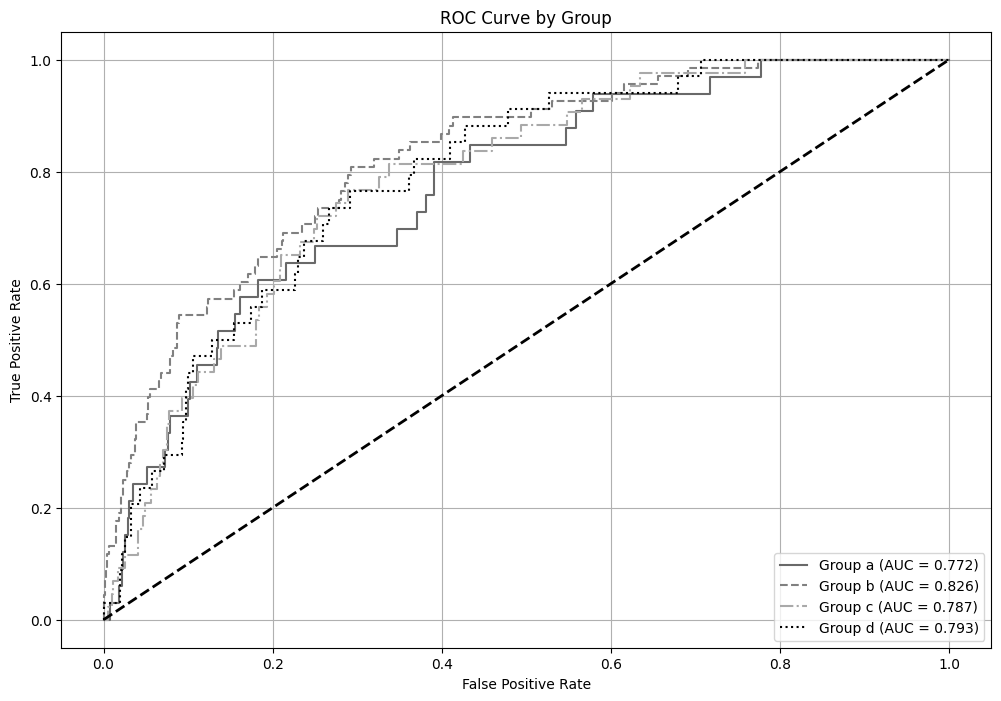

In [14]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(12, 8))

groups = ['a','b','c','d']
line_styles = ['-', '--', '-.', ':']
line_color=['dimgray','gray','darkgrey','black'] # Different dash styles for each group

for i, r in enumerate(groups):
    indices = fairness_df['sensitive_attribute'] == r
    y_true = fairness_df['true_label'][indices]
    y_pred = fairness_df['predicted_probability'][indices]
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=line_color[i % len(line_color)], linestyle=line_styles[i % len(line_styles)], label=f'Group {r} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Group')
plt.legend(loc='lower right')
plt.grid()
plt.show()

By shading the area that is under all the curves shows the feasible region where separation could be achieved.

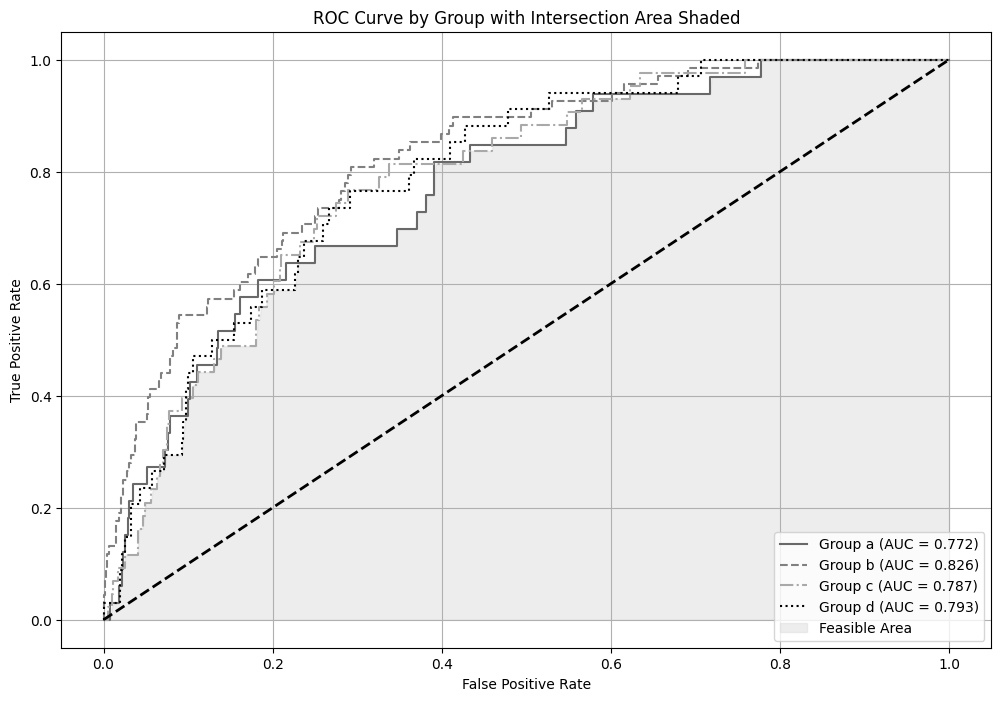

In [15]:
plt.figure(figsize=(12, 8))

roc_curves = []

groups = ['a','b','c','d']
line_styles = ['-', '--', '-.', ':']
line_color=['dimgray','gray','darkgrey','black']

for i,r in enumerate(groups):
    indices = fairness_df['sensitive_attribute'] == r
    y_true = fairness_df['true_label'][indices]
    y_pred = fairness_df['predicted_probability'][indices]
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=line_color[i % len(line_color)], linestyle=line_styles[i % len(line_styles)],label=f'Group {r} (AUC = {roc_auc:.3f})')
    roc_curves.append((fpr, tpr))


common_fpr = np.linspace(0, 1, 500)
interp_tprs = [np.interp(common_fpr, fpr, tpr) for fpr, tpr in roc_curves]
min_tpr = np.min(interp_tprs, axis=0)

plt.fill_between(common_fpr, min_tpr, color='gainsboro', alpha=0.5, label='Feasible Area')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Group with Intersection Area Shaded')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Sufficiency
Sufficiency requires independence between the sensitive attribute and the target variable, in the sense that people who get the same decision by the model have parity regardless of which group of $A$ they belong to.

We assess sufficiency by measuring the predictive rate parity which takes into account the precision of the models per group of the sensitive feature. We already have this measure in our dataframe.

We see in the output below that the predictive rate parity close to 0, meaning that in this regard the model fullfills the sufficiency fairness criteria.

In [16]:
metric_frame.difference()

,0
Count,1023.000000
Accuracy,0.055579
Selection rate,0.058126
Precision,0.018736
True positive rate,0.084131
True negative rate,0.056734
False positive rate,0.056734
False negative rate,0.084131


### Explainability
To create the plots in the book


In [ ]:
# Imports
import numpy as np
import os
import pandas as pd
import random
import shap

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
%matplotlib inline

# Huggingface
import transformers
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers.pipelines import pipeline
from transformers import set_seed
from datasets import load_dataset, Dataset, Value, ClassLabel, Features, load_from_disk
#import evaluate

In [ ]:
!gdown --id "1_KqbURS8BVRck9mj4DXjuRbD9SJIuz5r"

In [ ]:
!gdown --id '1ps8vhnNrMFyNbhLtO79UbsNEpiNZesEd'

In [ ]:
!unzip '/content/FEDSppechModel.zip'

In [ ]:
!gdown --id '1cqnUWh84nbbwfkcEfUGyPztWOtIeqOEf'

In [ ]:
!unzip '/content/TokenizedData.zip'

In [ ]:
FEDspeechesSHAP = pd.read_csv('/content/FEDSpeechesSHAP.csv')
FEDspeechesSHAP.head()

In [ ]:

speech1 = FEDspeechesSHAP.iloc[0]['text_cleaned']
speech2 = FEDspeechesSHAP.iloc[1]['text_cleaned']
speech3 = FEDspeechesSHAP.iloc[2]['text_cleaned']

print(len(speech1))
print(len(speech2))
print(len(speech3))

In [ ]:
# Create the dataset
fed_speech_data = Dataset.from_pandas(FEDspeechesSHAP.loc[:,['text_cleaned']])
fed_speech_data

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased",  processing_class=True)

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text_cleaned"], max_length=512, truncation=True)




In [ ]:
tokenized_fed_speech_data = fed_speech_data.map(preprocess_function)

In [ ]:
pipe = transformers.pipelines.pipeline('text-classification', truncation= True,model='FEDSppechModel', tokenizer=tokenizer, top_k=None,
                                  return_all_scores=True, device=0)


In [ ]:
pipe(tokenized_fed_speech_data['text_cleaned'])

In [ ]:
explainer = shap.Explainer(pipe)

In [ ]:
shap_values=explainer(tokenized_fed_speech_data['text_cleaned'])

In [ ]:
shap_values.shape

In [ ]:
shap.plots.text(shap_values)

In [ ]:
shap.plots.bar(shap_values[:,:,1].mean(0),order=shap.Explanation.argsort.flip, max_display=15)